# sprint 2

## classification of resaurant
When you get restaurant recommendations as a user you might want a functionality to filter out restaurants on price range. As a restaurant owner you might want to know what other restaurant features influence your price tag. That's why we want to create a classification model that classifies restaurants into cheap, medium of expensive categories.

To do this we will try out different clasifiers on default settings and then do a gridsearch on the most promising ones to get the best model

In [424]:
from fastai.imports import *
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns

original_df = pd.read_csv("tripadvisor_dataset/restaurant_listings.csv")
pd.set_option("display.max_columns", None)


in short, we will do the same preprocessing as we did in sprint 1

In [425]:
#see notebook sprint 1 for details on how we got this
coords=pd.read_csv("tripadvisor_dataset\coordinaten2.csv").replace(0,np.nan)

In [426]:
original_df["rank"]=original_df["rank"].str.replace("#","").astype(float)
original_df["general rating"]=original_df["general rating"].map(lambda x: x.split(" ")[0]).astype(float)
original_df["number of reviews"]=original_df["number of reviews"].map(lambda x: x.split(" ")[0].replace(",","")).astype(float)
original_df['city'] = original_df["address"].str.split(', ').str[-1].str.split(" ").str[0]
first_tag=original_df.tags.str.split("|",expand=True)[0].dropna()
ranges=first_tag[first_tag.str.find("$")!=-1]
original_df["price_tag"]=ranges
original_df=original_df.merge(coords,on="id")
original_df.drop(columns=["food rating", "service rating","price range"], inplace=True)

*NOTE* we can do this preprocessing on the original df because we are not aggregating data, each row is preprocessed individually (we are not using mean/mode/median/...)

In [427]:
original_df.columns

Index(['rank', 'restaurant name', 'general rating', 'number of reviews',
       'tags', 'address', 'phone number', 'website url', 'menu url',
       'timetable', 'email address', 'travelers choice', 'michelin',
       'value rating', 'atmosphere rating', 'description', 'dutch description',
       'cuisines', 'special diets', 'meals', 'restaurant features', 'id',
       'city', 'price_tag', 'latitude', 'longitude'],
      dtype='object')

now we will split the data and use a seed ;) but because we want to actually have price tags (our labels) we will remove them from our data first before making the train test split. In the end we can use our model to actually fill in the missing price tags 

In [428]:
df_with_price_tag=original_df[~original_df.price_tag.isna()].copy()

In [429]:
df_with_price_tag.price_tag

0       $$ - $$$
1           $$$$
2       $$ - $$$
3       $$ - $$$
4       $$ - $$$
          ...   
2563           $
2564           $
2566           $
2568    $$ - $$$
2574    $$ - $$$
Name: price_tag, Length: 1943, dtype: object

we will also remove features that won't help with the classification


In [430]:
df_with_price_tag.drop(columns=["restaurant name","address","phone number","website url","menu url","timetable","email address","id","tags"],inplace=True)

### descriptions

We can use the descriptions, we have 2 types. We will first see which ones are the most usefull

In [431]:
print(f"description is missing: {df_with_price_tag.description.isna().sum()}")
print(f"dutch description is missing {df_with_price_tag['dutch description'].isna().sum()}")
print(f"size trainingsset is {len(df_with_price_tag)}")

description is missing: 1497
dutch description is missing 1696
size trainingsset is 1943


we have too many missing values for description, 77% of the descriptions is missing so that's why we decided not to include this as a feature

In [432]:
df_with_price_tag.drop(columns=["description","dutch description"],inplace=True)
df_with_price_tag.head(2)

,rank,general rating,number of reviews,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,city,price_tag,latitude,longitude
0,1.0,5.0,922.0,True,False,4.5,-1.0,"Thai, Healthy","Vegetarian Friendly, Vegan Options, Gluten Free Options","Dinner, Drinks","Reservations, Seating, Serves Alcohol, Free Wifi, Table Service, Gift Cards Available",Ghent,$$ - $$$,51.054899,3.722325
1,1.0,5.0,200.0,False,True,4.5,5.0,"French, Belgian, European","Vegetarian Friendly, Vegan Options, Gluten Free Options","Lunch, Dinner","Free Wifi, Reservations, Outdoor Seating, Seating, Parking Available, Free off-street parking, Wheelchair Accessible, Serves Alcohol, Accepts American Express, Accepts Mastercard, Accepts Visa, Accepts Credit Cards, Table Service, Highchairs Available, Full Bar",Ninove,$$$$,50.788705,4.052820


### splitting the data

In [433]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_with_price_tag,test_size=0.2,train_size=0.8,shuffle=True,random_state=42)


In [434]:
df_train.price_tag.value_counts()

$$ - $$$    1244
$            250
$$$$          60
Name: price_tag, dtype: int64

There is a big class imabalance in our training data, we have to take this into account. 
We have multiple options to handle this class imbalance, the first option is to continue with the imbalanced dataset.When choosing our models we will look for algorithms that have the class weight property so we can assign the corresponding weight to each class.

The second option is to artificially oversample our minority classes or downsample our majority classes. 

Before we start with the feature engineering part I would start by making a baseline classifier, the random forest. I chose to do this because it is very difficult to do something wrong here, it is insensitive to outliers and does not require feature scaling. The results are also interpretable, we can see which features are used to split our data (the most important features) and we can focus on those in our other classifier models.


inspiration from [this](https://www.kaggle.com/code/jhoward/how-random-forests-really-work) notebook used in the course [Practical Deep Learning for Coders 2022](https://www.youtube.com/watch?v=8SF_h3xF3cE&list=PLfYUBJiXbdtSvpQjSnJJ_PmDQB_VyT5iU&ab_channel=JeremyHoward)

peronally I also wanted to experiment a bit with pipelines so I got some inspiration from [this blog](https://towardsdatascience.com/getting-the-most-out-of-scikit-learn-pipelines-c2afc4410f1a#:~:text=They%20can%20be%20nested%20and,(model)%20at%20the%20end.)

In [435]:
rf_train=df_train.copy()
rf_test=df_test.copy()

In [436]:
rf_train.head(1)

,rank,general rating,number of reviews,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,city,price_tag,latitude,longitude
1817,4.0,3.5,21.0,False,False,3.0,-1.0,"Seafood, Belgian, European",NaN,Dinner,"Reservations, Seating, Table Service, Wheelchair Accessible",Denderleeuw,$$ - $$$,50.888222,4.076788


In [437]:
numeric=["rank","general rating","number of reviews","value rating","atmosphere rating","latitude","longitude"]
mutlihot_col = ['cuisines','special diets',"meals","restaurant features"]
cat_cols = ['travelers choice', 'michelin', 'city']#one hot encoding
label="price_tag"

In [438]:
for col in mutlihot_col:
    rf_train[col]=rf_train[col].fillna("X").str.replace(" ","").str.split(",")

ColumnTransformers are built similarly to Pipelines, except you include a third value in each tuple representing the columns to be transformed in that step.

In [439]:
rf_train.head(2)

,rank,general rating,number of reviews,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,city,price_tag,latitude,longitude
1817,4.0,3.5,21.0,False,False,3.0,-1.0,"[Seafood, Belgian, European]",[X],[Dinner],"[Reservations, Seating, TableService, WheelchairAccessible]",Denderleeuw,$$ - $$$,50.888222,4.076788
867,6.0,4.0,44.0,False,False,4.0,-1.0,"[Belgian, Dutch, European]",[VegetarianFriendly],"[Dinner, Drinks]","[Reservations, Seating, ServesAlcohol, TableService]",Brakel,$$ - $$$,NaN,NaN


In [440]:
from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import MultiLabelBinarizer

from help_script import MultiHotEncoder

cols_trans = ColumnTransformer([
    ('mhe',MultiHotEncoder(),mutlihot_col),
    ('ohe', OneHotEncoder(drop='first'), cat_cols), 
    ('imputing',SimpleImputer(),numeric),
    ('scaling',StandardScaler(),numeric)
    ])

In [441]:
pipe = Pipeline([
    ('trans', cols_trans),
    ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
])

In [442]:
pipe

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('mhe', MultiHotEncoder(),
                                                  ['cuisines', 'special diets',
                                                   'meals',
                                                   'restaurant features']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['travelers choice',
                                                   'michelin', 'city']),
                                                 ('imputing', SimpleImputer(),
                                                  ['rank', 'general rating',
                                                   'number of reviews',
                                                   'value rating',
                                                   'atmosphere rating',
                                                   'latitude', 'longitude']),
                                                 ('scaling', StandardScaler(),
                                                  ['rank', 'general rating',
                                                   'number of reviews',
                                                   'value rating',
                                                   'atmosphere rating',
                                                   'latitude',
                                                   'longitude'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [443]:
# pipe.fit(rf_train,rf_train["price_tag"])

In [444]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(100, min_samples_leaf=5)
# rf.fit(trn_xs, trn_y);
# mean_absolute_error(val_y, rf.predict(val_xs))

now let's start with the feature engineering part, as we've learned our model can only interpret numbers so as input we must turn all our attributes into numerical values

for the attributes that are already numerical we can look for feature scaling methods.

### numerical values

In [445]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_cols=df_train.select_dtypes(numerics).columns

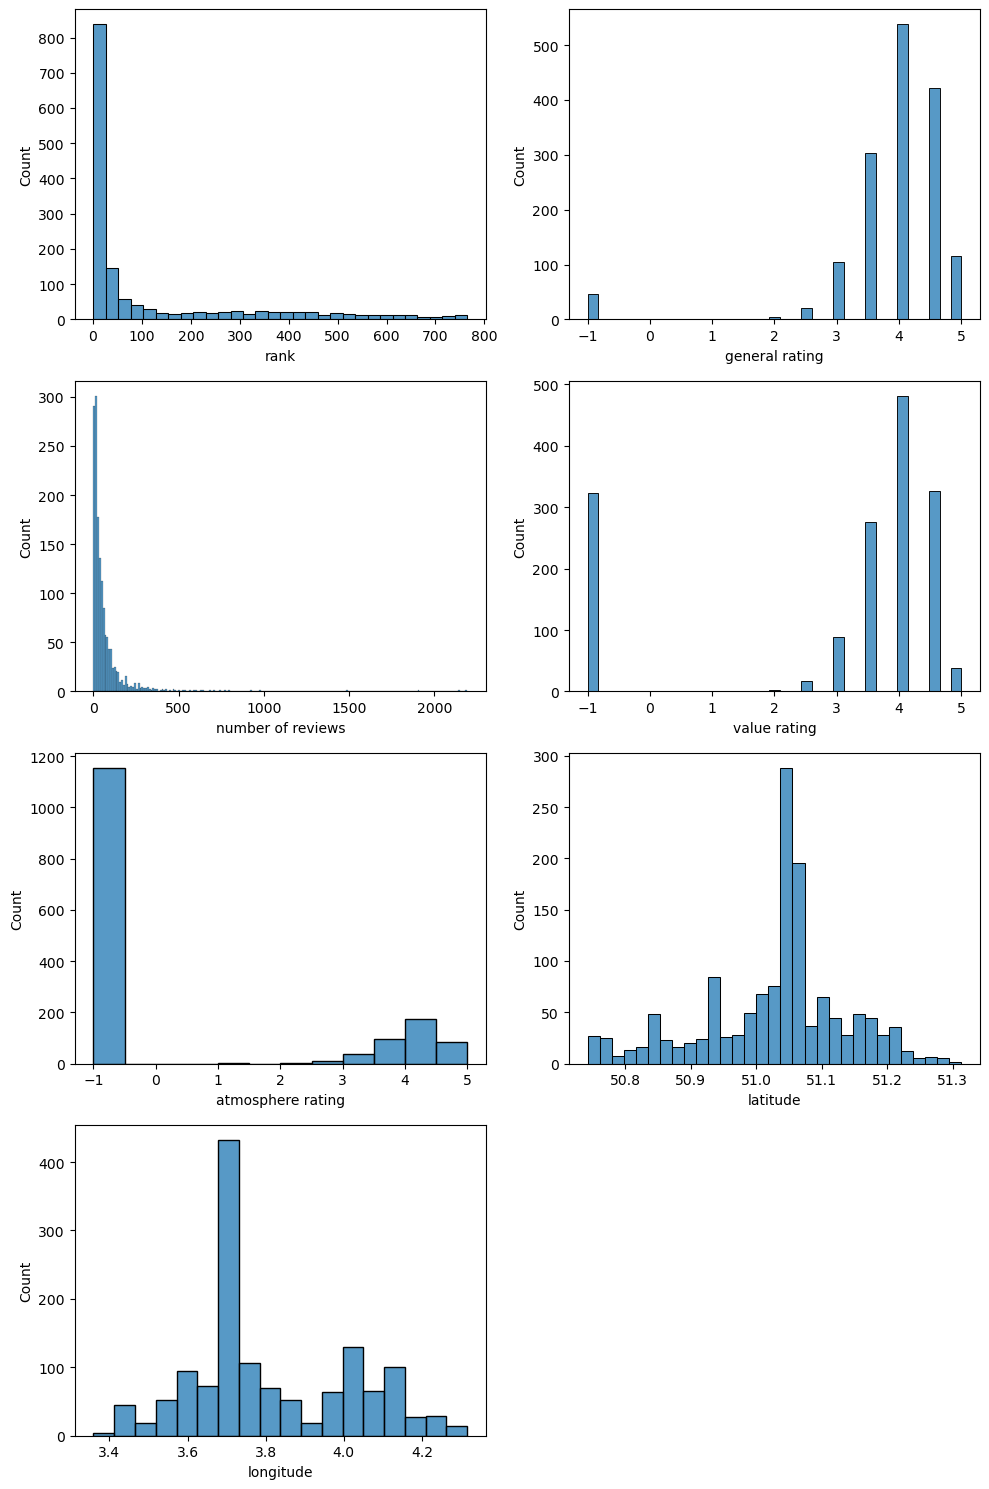

In [446]:
fig=plt.figure(figsize=(10,15))
for i, col in enumerate(numerical_cols):
    plt.subplot(4,2,i+1)
    sns.histplot(df_train[col])
fig.tight_layout()
plt.show()

#### rank and number of reviews

we can see the rank and number of reviews have along tail distribution so I would take the log of the data first, and then apply standardization.

d:\programmas_unif\miniconda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


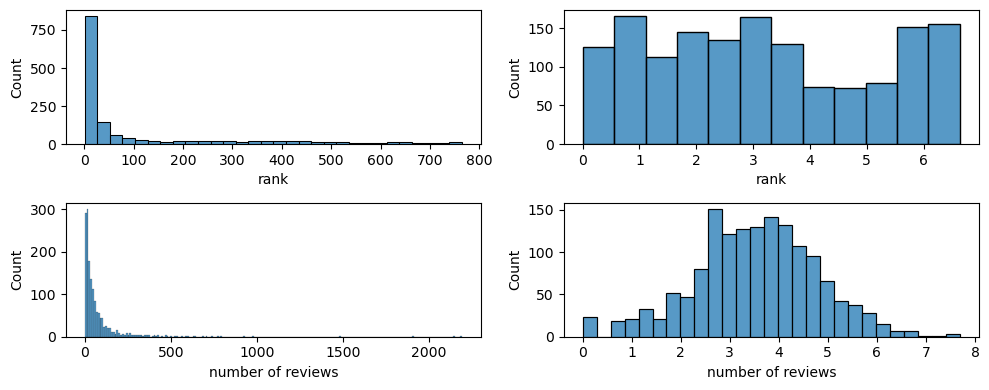

In [447]:
fig=plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
sns.histplot(df_train["rank"])
plt.subplot(2,2,2)
sns.histplot(np.log(df_train["rank"]))
plt.subplot(2,2,3)
sns.histplot(df_train["number of reviews"])
plt.subplot(2,2,4)
sns.histplot(np.log(df_train["number of reviews"]))
fig.tight_layout()
plt.show()


It already looks so much better! we will keep this but because sometimes the number of reviews is zero we will add a +1

In [448]:
##WE WILL DO THIS AFTER IMPUTATION
# df_train["lg_rank"]=np.log(df_train["rank"])
# df_train["lg_reviews"]=np.log(df_train["number of reviews"]+1)

#### general rating, atmosphere rating and value rating

look at these three again without the -1's

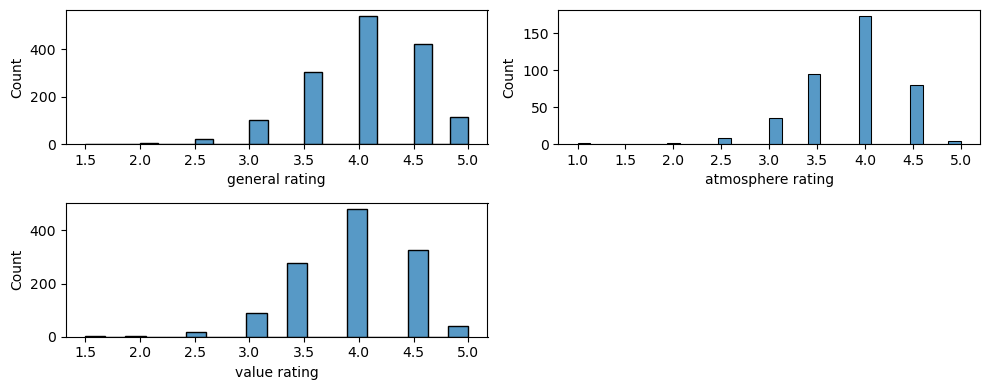

In [449]:
fig=plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
sns.histplot(df_train["general rating"].replace(-1,np.nan))
plt.subplot(2,2,2)
sns.histplot(df_train["atmosphere rating"].replace(-1,np.nan))
plt.subplot(2,2,3)
sns.histplot(df_train["value rating"].replace(-1,np.nan))
fig.tight_layout()
plt.show()

this already looks acceptable

#### lat & lon
for the coordinates we think it's best just to apply standardization to them

and for the missing data we wrote a script that derives the center latitude and longitude from the city and we will fill it in with those coordinates

In [450]:
city_centers=pd.read_csv("sprint1\city_centers.csv")

In [451]:
df_train=df_train.merge(city_centers,on="city")
df_train

,rank,general rating,number of reviews,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,city,price_tag,latitude,longitude,Unnamed: 0,latitude_center,longitude_center
0,4.0,3.5,21.0,False,False,3.0,-1.0,"Seafood, Belgian, European",NaN,Dinner,"Reservations, Seating, Table Service, Wheelchair Accessible",Denderleeuw,$$ - $$$,50.888222,4.076788,81,50.888138,4.062511
1,2.0,3.5,44.0,False,False,3.5,-1.0,"Italian, Pizza",Vegetarian Friendly,Dinner,"Takeout, Reservations, Seating, Wheelchair Accessible, Table Service, Serves Alcohol",Denderleeuw,$$ - $$$,50.891975,4.073112,81,50.888138,4.062511
2,1.0,4.0,207.0,False,False,4.0,3.5,"Belgian, Bar, European",Vegetarian Friendly,"Lunch, Dinner, Late Night","Reservations, Outdoor Seating, Seating, Wheelchair Accessible, Serves Alcohol, Full Bar, Table Service, Highchairs Available",Denderleeuw,$$ - $$$,50.872612,4.079612,81,50.888138,4.062511
3,6.0,4.0,44.0,False,False,4.0,-1.0,"Belgian, Dutch, European",Vegetarian Friendly,"Dinner, Drinks","Reservations, Seating, Serves Alcohol, Table Service",Brakel,$$ - $$$,NaN,NaN,9,50.797974,3.762778
4,8.0,4.5,25.0,False,False,-1.0,-1.0,"Belgian, Dutch, European",NaN,"Dinner, Breakfast, Lunch","Reservations, Seating, Table Service, Wheelchair Accessible",Brakel,$$ - $$$,50.803700,3.764335,9,50.797974,3.762778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,1.0,3.0,22.0,False,False,3.5,-1.0,NaN,NaN,"Lunch, Dinner","Reservations, Seating, Table Service",Kaprijke,$$ - $$$,51.218950,3.617083,165,51.218508,3.619077
1550,2.0,4.5,8.0,False,False,-1.0,-1.0,NaN,NaN,"Lunch, Dinner",NaN,Nukerke,$$ - $$$,50.801908,3.592342,95,50.796561,3.595467
1551,2.0,4.5,7.0,False,False,5.0,-1.0,"French, Belgian, Cafe, Seafood, European, Pub",NaN,"Lunch, Dinner, Drinks","Reservations, Takeout, Private Dining, Street Parking, Television, Serves Alcohol, Wine and Beer, Free Wifi, Accepts Credit Cards, Table Service, Dog Friendly, Family style, Non-smoking restaurants, Gift Cards Available",Denderhoutem,$$ - $$$,NaN,NaN,127,50.871780,4.018084
1552,1.0,4.0,17.0,False,False,4.5,-1.0,"Deli, Healthy, European",NaN,"Breakfast, Brunch, Lunch","Reservations, Outdoor Seating, Buffet, Seating, Parking Available, Street Parking, Highchairs Available, Serves Alcohol, Wine and Beer, Cash Only, Free Wifi, Table Service, Takeout",Aaigem,$$ - $$$,50.891996,3.949188,122,50.889417,3.936691


In [452]:
df_train.loc[df_train.latitude.isna(),"latitude"]=df_train[df_train.latitude.isna()].latitude_center
df_train.loc[df_train.longitude.isna(),"longitude"]=df_train[df_train.longitude.isna()].longitude_center

In [453]:
df_train.latitude.isna().sum()
# df_train.loc[df_train.latitude.isna(),"latitude"]

0

In [454]:
df_train.drop(columns=["Unnamed: 0","latitude_center","longitude_center"],inplace=True)

In [455]:
df_train.columns

Index(['rank', 'general rating', 'number of reviews', 'travelers choice',
       'michelin', 'value rating', 'atmosphere rating', 'cuisines',
       'special diets', 'meals', 'restaurant features', 'city', 'price_tag',
       'latitude', 'longitude'],
      dtype='object')

#### Missing values
Because our model won't like NANs we have to replace them by something. We decided to replace them with the median of the corresponding feature. But  we also think having a missing value can actually be a very good predictor. Thats why we will add a "missing" column when we have a missing value

In [456]:
df_train["rank_missing"]=0
df_train["atmosphere_missing"]=0
df_train["value_missing"]=0
df_train["general_missing"]=0

In [457]:
df_train["atmosphere rating"]=df_train["atmosphere rating"].replace(-1,np.nan)
df_train["value rating"]=df_train["value rating"].replace(-1,np.nan)
df_train["general rating"]=df_train["general rating"].replace(-1,np.nan)

In [458]:
df_train.loc[df_train["rank"].isna(),"rank_missing"] = 1
df_train.loc[df_train["atmosphere rating"].isna(),"atmosphere_missing"] = 1
df_train.loc[df_train["value rating"].isna(),"value_missing"] = 1
df_train.loc[df_train["general rating"].isna(),"general_missing"] = 1

imputing our missing values with the median

In [459]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_data=imp_mean.fit_transform(df_train[["rank","general rating","value rating","atmosphere rating"]])
imputed_data

array([[4. , 3.5, 3. , 4. ],
       [2. , 3.5, 3.5, 4. ],
       [1. , 4. , 4. , 3.5],
       ...,
       [2. , 4.5, 5. , 4. ],
       [1. , 4. , 4.5, 4. ],
       [1. , 4. , 4.5, 4. ]])

In [460]:
df_train["rank"]=imputed_data[:,0]
df_train["general rating"]=imputed_data[:,1]
df_train["value rating"]=imputed_data[:,2]
df_train["atmosphere rating"]=imputed_data[:,3]

scaling and then standardising

In [461]:
df_train["lg_rank"]=np.log(df_train["rank"])
df_train["lg_reviews"]=np.log(df_train["number of reviews"]+1)
df_train.drop(columns=["rank","number of reviews"],inplace=True)

In [462]:
df_train.head(1)

,general rating,travelers choice,michelin,value rating,atmosphere rating,cuisines,special diets,meals,restaurant features,city,price_tag,latitude,longitude,rank_missing,atmosphere_missing,value_missing,general_missing,lg_rank,lg_reviews
0,3.5,False,False,3.0,4.0,"Seafood, Belgian, European",NaN,Dinner,"Reservations, Seating, Table Service, Wheelchair Accessible",Denderleeuw,$$ - $$$,50.888222,4.076788,0,1,0,0,1.386294,3.091042


### booleans

In [463]:
df_train.select_dtypes(bool)

,travelers choice,michelin
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
1549,False,False
1550,False,False
1551,False,False
1552,False,False


In [464]:
df_train.select_dtypes(bool).isna().sum()

travelers choice    0
michelin            0
dtype: int64

no missing values! turn these into zeros and ones

In [465]:
df_train["travelers choice"]=df_train["travelers choice"].astype(int)
df_train["michelin"]=df_train["michelin"].astype(int)

### encoding categorical variables

we already explained how we did this and used it in our sprint 1 notebook so excuse us for just copy pasting the code 😅

In [466]:
mutlihot_col = ['cuisines','special diets',"meals","restaurant features"]

In [467]:
for col in mutlihot_col:
    df_train[col]=df_train[col].fillna(col+"_missing").str.replace(" ","").str.split(",")

In [468]:
df_train[mutlihot_col]

,cuisines,special diets,meals,restaurant features
0,"[Seafood, Belgian, European]",[specialdiets_missing],[Dinner],"[Reservations, Seating, TableService, WheelchairAccessible]"
1,"[Italian, Pizza]",[VegetarianFriendly],[Dinner],"[Takeout, Reservations, Seating, WheelchairAccessible, TableService, ServesAlcohol]"
2,"[Belgian, Bar, European]",[VegetarianFriendly],"[Lunch, Dinner, LateNight]","[Reservations, OutdoorSeating, Seating, WheelchairAccessible, ServesAlcohol, FullBar, TableService, HighchairsAvailable]"
3,"[Belgian, Dutch, European]",[VegetarianFriendly],"[Dinner, Drinks]","[Reservations, Seating, ServesAlcohol, TableService]"
4,"[Belgian, Dutch, European]",[specialdiets_missing],"[Dinner, Breakfast, Lunch]","[Reservations, Seating, TableService, WheelchairAccessible]"
...,...,...,...,...
1549,[cuisines_missing],[specialdiets_missing],"[Lunch, Dinner]","[Reservations, Seating, TableService]"
1550,[cuisines_missing],[specialdiets_missing],"[Lunch, Dinner]",[restaurantfeatures_missing]
1551,"[French, Belgian, Cafe, Seafood, European, Pub]",[specialdiets_missing],"[Lunch, Dinner, Drinks]","[Reservations, Takeout, PrivateDining, StreetParking, Television, ServesAlcohol, WineandBeer, FreeWifi, AcceptsCreditCards, TableService, DogFriendly, Familystyle, Non-smokingrestaurants, GiftCardsAvailable]"
1552,"[Deli, Healthy, European]",[specialdiets_missing],"[Breakfast, Brunch, Lunch]","[Reservations, OutdoorSeating, Buffet, Seating, ParkingAvailable, StreetParking, HighchairsAvailable, ServesAlcohol, WineandBeer, CashOnly, FreeWifi, TableService, Takeout]"


In [469]:
#multi hot encoding of the meals, restaurant features ,cuisines and diets
from sklearn.preprocessing import MultiLabelBinarizer

mlbs=[]
columns=["meals","restaurant features","cuisines","special diets"]
mh_encodings=[]
for col in columns:
    mlb= MultiLabelBinarizer()
    mlbs.append(mlb)
    # X=df_train[col].str.replace(" ","").str.split(",").fillna("X").to_list()
    #I want a list of sets that i can then pass to the MultiLabelBinarizer
    # lijst=[set(i) for i in X]
    mh_encodings.append(mlb.fit_transform(df_train[col]))


In [470]:
for i in mh_encodings:
    print(i.shape)

(1554, 7)
(1554, 39)
(1554, 91)
(1554, 5)


In [471]:
for i in mlbs:
    print(i.classes_)

['Breakfast' 'Brunch' 'Dinner' 'Drinks' 'LateNight' 'Lunch'
 'meals_missing']
['AcceptsAmericanExpress' 'AcceptsCreditCards' 'AcceptsDiscover'
 'AcceptsMastercard' 'AcceptsVisa' 'BYOB' 'Beach' 'Buffet' 'CashOnly'
 'Delivery' 'DigitalPayments' 'DogFriendly' 'Familystyle' 'FreeWifi'
 'Freeoff-streetparking' 'FullBar' 'GiftCardsAvailable'
 'HighchairsAvailable' 'JazzBar' 'LiveMusic' 'Non-smokingrestaurants'
 'OutdoorSeating' 'ParkingAvailable' 'Playgrounds' 'PrivateDining'
 'Reservations' 'Seating' 'ServesAlcohol' 'Sportsbars' 'StreetParking'
 'TableService' 'Takeout' 'Television' 'ValetParking' 'ValidatedParking'
 'Waterfront' 'WheelchairAccessible' 'WineandBeer'
 'restaurantfeatures_missing']
['Afghan' 'African' 'Albanian' 'American' 'Apulian' 'Arabic' 'Argentinean'
 'Asian' 'Assyrian' 'Australian' 'Bar' 'Barbecue' 'Beerrestaurants'
 'Belgian' 'Brazilian' 'BrewPub' 'British' 'Cafe' 'Cajun&Creole'
 'Campania' 'Caribbean' 'Central-Italian' 'CentralAmerican' 'CentralAsian'
 'CentralEuropea

one hot encode the city

In [472]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder(sparse=False,handle_unknown="infrequent_if_exist")
enc.fit(np.array(df_train["city"]).reshape(-1,1))
oh_cities=enc.transform(np.array(df_train["city"]).reshape(-1,1))
oh_cities

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [473]:
df_train.drop(columns=["cuisines","special diets","meals","restaurant features","city"],inplace=True)
df_train

,general rating,travelers choice,michelin,value rating,atmosphere rating,price_tag,latitude,longitude,rank_missing,atmosphere_missing,value_missing,general_missing,lg_rank,lg_reviews
0,3.5,0,0,3.0,4.0,$$ - $$$,50.888222,4.076788,0,1,0,0,1.386294,3.091042
1,3.5,0,0,3.5,4.0,$$ - $$$,50.891975,4.073112,0,1,0,0,0.693147,3.806662
2,4.0,0,0,4.0,3.5,$$ - $$$,50.872612,4.079612,0,0,0,0,0.000000,5.337538
3,4.0,0,0,4.0,4.0,$$ - $$$,50.797974,3.762778,0,1,0,0,1.791759,3.806662
4,4.5,0,0,4.0,4.0,$$ - $$$,50.803700,3.764335,0,1,1,0,2.079442,3.258097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,3.0,0,0,3.5,4.0,$$ - $$$,51.218950,3.617083,0,1,0,0,0.000000,3.135494
1550,4.5,0,0,4.0,4.0,$$ - $$$,50.801908,3.592342,0,1,1,0,0.693147,2.197225
1551,4.5,0,0,5.0,4.0,$$ - $$$,50.871780,4.018084,0,1,0,0,0.693147,2.079442
1552,4.0,0,0,4.5,4.0,$$ - $$$,50.891996,3.949188,0,1,0,0,0.000000,2.890372


### standardizing

In [474]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data=scaler.fit_transform(df_train[["general rating","value rating","atmosphere rating","latitude","longitude","lg_rank","lg_reviews"]])
scaled_data.shape

(1554, 7)

In [475]:
df_train["general rating"]=scaled_data[:,0]
df_train["value rating"]=scaled_data[:,1]
df_train["atmosphere rating"]=scaled_data[:,2]
df_train["latitude"]=scaled_data[:,3]
df_train["longitude"]=scaled_data[:,4]
df_train["lg_rank"]=scaled_data[:,5]
df_train["lg_reviews"]=scaled_data[:,6]

### label

our label is the pice tag, we will ordinal encode this

In [476]:
df_train.loc[df_train.price_tag=="$","price_tag"]=0
df_train.loc[df_train.price_tag=="$$ - $$$","price_tag"]=1
df_train.loc[df_train.price_tag=="$$$$","price_tag"]=2

In [477]:
y_train=df_train["price_tag"].astype(int)
df_train.drop(columns=["price_tag"],inplace=True)

finally putting it all together

In [478]:
oh_cities.shape

(1554, 145)

In [479]:
mh_encodings[0].shape

(1554, 7)

In [480]:
##testing if the shape is correct
np.concatenate((oh_cities,mh_encodings[0]),axis=1).shape

(1554, 152)

In [481]:
df_train

,general rating,travelers choice,michelin,value rating,atmosphere rating,latitude,longitude,rank_missing,atmosphere_missing,value_missing,general_missing,lg_rank,lg_reviews
0,-0.942944,0,0,-2.093911,0.134304,-1.228275,1.240307,0,1,0,0,-0.920493,-0.286641
1,-0.942944,0,0,-1.007092,0.134304,-1.194586,1.223032,0,1,0,0,-1.272906,0.255239
2,-0.032798,0,0,0.079728,-1.696477,-1.368416,1.253582,0,0,0,0,-1.625319,1.414445
3,-0.032798,0,0,0.079728,0.134304,-2.038458,-0.235375,0,1,0,0,-0.714345,0.255239
4,0.877348,0,0,0.079728,0.134304,-1.987050,-0.228057,0,1,1,0,-0.568081,-0.160145
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549,-1.853091,0,0,-1.007092,0.134304,1.740752,-0.920066,0,1,0,0,-1.625319,-0.252981
1550,0.877348,0,0,0.079728,0.134304,-2.003139,-1.036335,0,1,1,0,-1.272906,-0.963455
1551,0.877348,0,0,2.253367,0.134304,-1.375886,0.964430,0,1,0,0,-1.272906,-1.052643
1552,-0.032798,0,0,1.166548,0.134304,-1.194395,0.640657,0,1,0,0,-1.625319,-0.438592


In [482]:
X_train=np.concatenate((oh_cities,mh_encodings[0],mh_encodings[1],mh_encodings[2],mh_encodings[3],df_train),axis=1)
X_train.shape

(1554, 300)

we will also make a variable, feature labels that will tell us where each feature in our array comes from

In [483]:
feature_labels=[]

In [484]:
feature_labels.extend(enc.categories_[0])
for i in mlbs:
    feature_labels.extend(i.classes_)
feature_labels.extend(df_train.columns)

In [485]:
len(feature_labels), feature_labels[:3]

(300, ['Aaigem', 'Aalst', 'Aalter'])

#### now apply the same preprocessing for our test set


first, fill in the missing locations with the city_centers

In [486]:
df_test=df_test.merge(city_centers,on="city")

In [487]:
df_test.loc[df_test.latitude.isna(),"latitude"]=df_test[df_test.latitude.isna()].latitude_center
df_test.loc[df_test.longitude.isna(),"longitude"]=df_test[df_test.longitude.isna()].longitude_center

In [488]:
df_test.latitude.isna().sum()

0

In [489]:
df_test.drop(columns=["Unnamed: 0","latitude_center","longitude_center"],inplace=True)

In [490]:
#inserting the missing columns
df_test["rank_missing"]=0
df_test["atmosphere_missing"]=0
df_test["value_missing"]=0
df_test["general_missing"]=0
df_test["atmosphere rating"]=df_test["atmosphere rating"].replace(-1,np.nan)
df_test["value rating"]=df_test["value rating"].replace(-1,np.nan)
df_test["general rating"]=df_test["general rating"].replace(-1,np.nan)
df_test.loc[df_test["rank"].isna(),"rank_missing"] = 1
df_test.loc[df_test["atmosphere rating"].isna(),"atmosphere_missing"] = 1
df_test.loc[df_test["value rating"].isna(),"value_missing"] = 1
df_test.loc[df_test["general rating"].isna(),"general_missing"] = 1


imputing our data

In [491]:
#inputing our data
imputed_data=imp_mean.transform(df_test[["rank","general rating","value rating","atmosphere rating"]])
print(imputed_data.shape)
df_test["rank"]=imputed_data[:,0]
df_test["general rating"]=imputed_data[:,1]
df_test["value rating"]=imputed_data[:,2]
df_test["atmosphere rating"]=imputed_data[:,3]
df_test["lg_rank"]=np.log(df_test["rank"])
df_test["lg_reviews"]=np.log(df_test["number of reviews"]+1)
df_test.drop(columns=["rank","number of reviews"],inplace=True)
df_test["travelers choice"]=df_test["travelers choice"].astype(int)
df_test["michelin"]=df_test["michelin"].astype(int)

(389, 4)


multihot encoding

In [492]:
for col in mutlihot_col:
    df_test[col]=df_test[col].fillna(col+"_missing").str.replace(" ","").str.split(",")

In [493]:
#multihot encoding
# mlbs=[]
columns=["meals","restaurant features","cuisines","special diets"]
mh_encodings=[]
for i,col in enumerate(columns):
    mlb= mlbs[i]
    mh_encodings.append(mlb.transform(df_test[col]))


d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['DriveThru'] will be ignored
  warnings.warn(
d:\programmas_unif\miniconda\lib\site-packages\sklearn\preprocessing\_label.py:878: UserWarning: unknown class(es) ['Ethiopian', 'Filipino', 'Malaysian', 'Taiwanese'] will be ignored
  warnings.warn(


we can already see that there are classs in our test set that don't appear in our trainingsset, we will ignore these

In [494]:
#OH encoding
# enc=OneHotEncoder(sparse=False,handle_unknown="infrequent_if_exist")
enc.transform(np.array(df_test["city"]).reshape(-1,1))
oh_cities=enc.transform(np.array(df_test["city"]).reshape(-1,1))
df_test.drop(columns=["cuisines","special diets","meals","restaurant features","city"],inplace=True)


In [495]:
#scaling
# scaler = StandardScaler()
scaled_data=scaler.transform(df_test[["general rating","value rating","atmosphere rating","latitude","longitude","lg_rank","lg_reviews"]])
scaled_data.shape
df_test["general rating"]=scaled_data[:,0]
df_test["value rating"]=scaled_data[:,1]
df_test["atmosphere rating"]=scaled_data[:,2]
df_test["latitude"]=scaled_data[:,3]
df_test["longitude"]=scaled_data[:,4]
df_test["lg_rank"]=scaled_data[:,5]
df_test["lg_reviews"]=scaled_data[:,6]
df_test.loc[df_test.price_tag=="$","price_tag"]=0
df_test.loc[df_test.price_tag=="$$ - $$$","price_tag"]=1
df_test.loc[df_test.price_tag=="$$$$","price_tag"]=2

y_test=df_test["price_tag"].astype(int)
df_test.drop(columns=["price_tag"],inplace=True)



In [496]:
X_test=np.concatenate((oh_cities,mh_encodings[0],mh_encodings[1],mh_encodings[2],mh_encodings[3],df_test),axis=1)

In [497]:
X_train.shape,y_train.shape, X_test.shape,y_test.shape

((1554, 300), (1554,), (389, 300), (389,))

### baseline

In [534]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=1)
rf.fit(X_train, y_train)
balanced_accuracy_score(y_test, rf.predict(X_test))

0.45090956340956345

this is already a good result, we can also find the features that were used the most in the descision trees to make splits (the important features)

In [535]:
rf.feature_importances_

array([0.00000000e+00, 3.87354132e-03, 6.36959134e-04, 1.15375318e-03,
       1.39434499e-07, 0.00000000e+00, 1.69664873e-04, 1.53671695e-04,
       2.08760842e-04, 9.08872460e-05, 1.13159193e-03, 1.34268405e-04,
       1.53289351e-04, 9.93845981e-04, 5.19655010e-05, 5.50685908e-04,
       4.78486037e-06, 2.04481614e-03, 0.00000000e+00, 6.14271803e-04,
       1.71464729e-04, 7.74906455e-04, 1.21128757e-03, 5.54689373e-05,
       2.09339783e-05, 3.86589786e-03, 2.28649126e-03, 3.74090910e-06,
       2.85156384e-05, 5.85720249e-07, 1.44701579e-03, 0.00000000e+00,
       1.89622750e-03, 4.97627381e-05, 6.37198969e-06, 1.03687730e-04,
       8.62420572e-05, 1.15184599e-07, 1.28668842e-04, 9.06659113e-04,
       2.79479050e-03, 3.06802201e-05, 1.92339805e-03, 1.48931952e-02,
       2.62767908e-05, 8.50151196e-04, 0.00000000e+00, 1.73222505e-03,
       4.49928502e-04, 3.52021925e-06, 2.80345286e-05, 1.93085199e-05,
       5.76092150e-05, 5.11646276e-04, 9.21102401e-04, 8.11658981e-04,
      

In [536]:
importances=pd.DataFrame(dict(cols=feature_labels, imp=rf.feature_importances_))

In [537]:
importances.sort_values("imp",ascending=False).head(10)

,cols,imp
299,lg_reviews,0.066822
293,longitude,0.066758
298,lg_rank,0.064146
292,latitude,0.061605
287,general rating,0.034374
177,Reservations,0.030876
290,value rating,0.029631
182,TableService,0.028205
183,Takeout,0.016928
147,Dinner,0.016025


above we can see  the 10 most important features for our random forest ensemble. It is interesting to see that we were right, the fact that a feature is missing is important for the classifier, "restaurant features missing" is in the top 10 as a feature. It is also interesting to see that Table service and reviews are the most inmortant features to determine our price tag

### model selection

our first idea was to try out a lot of different classifiers with default parameters, look which ones have the best accuracy and then do a grid search on the best 3 models and pich the best one. When we finished this we realised that our dataset is heavily imbalanced and we have to do something about this.


*NOTE: we have class imabalance so we chose models that have the class weight property*

we must choose our performance metric carefully because of the class imbalance [this article]("https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a") for inspiration

In [502]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
def plot_cm(classifier):
    cm=confusion_matrix(y_test, classifier.predict(X_test))
    df_cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'

    sns.heatmap(df_cm, cbar=False, annot=True, square=True, fmt='.0f',
                annot_kws={'size': 10})

In [503]:
classifiers=["svc linear","svc rbf","Logistic Regression","Naive Bayes","Light Gradient Boosting machine(LGBM)","xgboost","catboost"]
scores_list=[]

**svc linear**

quick experiment to see the effect of the class weight

In [504]:
clf=SVC(kernel="linear", C=0.025)
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)

The score is:  0.7634961439588689
The balanced accuracy is:  0.33749999999999997


In [505]:
clf=SVC(kernel="linear", C=0.025,class_weight="balanced")
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.6735218508997429
The balanced accuracy is:  0.670556133056133


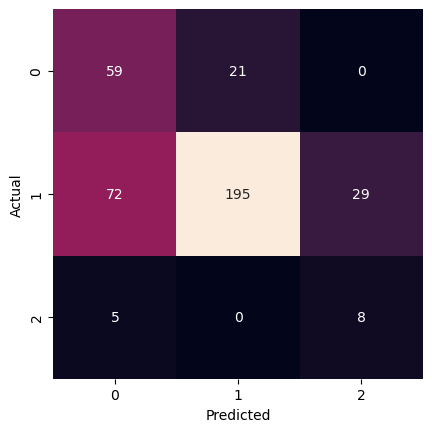

In [506]:
plot_cm(clf)

**svc rbf**


In [507]:
clf = SVC(gamma=2, C=1,class_weight="balanced")
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.7583547557840618
The balanced accuracy is:  0.3322072072072072


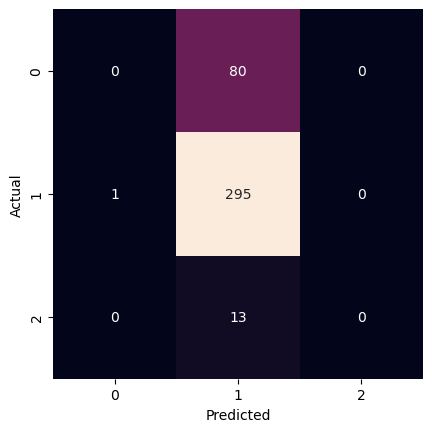

In [508]:
plot_cm(clf)

we can already see that by carefully looking at the confusion matrix and not blindly at our classification score we can already see that eventhough this classifier has a better score that the linear SVC, it predicts 1 for almost every input so the model is actually really bad

we can also confirm that the balanced accuracy is a better performance metric

**logistic geression**

In [509]:
clf=LogisticRegression(random_state=0,max_iter=500,class_weight="balanced")
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.6838046272493573
The balanced accuracy is:  0.6414241164241163


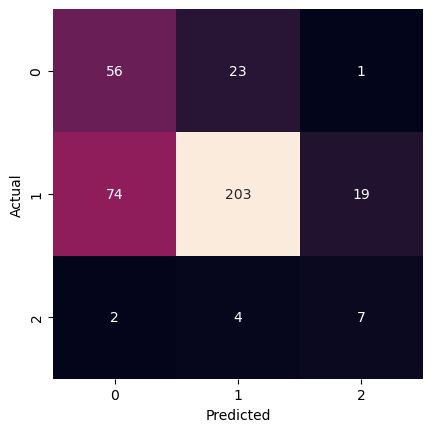

In [510]:
plot_cm(clf)

**Naieve Bayes**

In [511]:
clf=GaussianNB() ##here we don't need class weights because the probabilities are calculated from our classes
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.29048843187660667
The balanced accuracy is:  0.42332813582813583


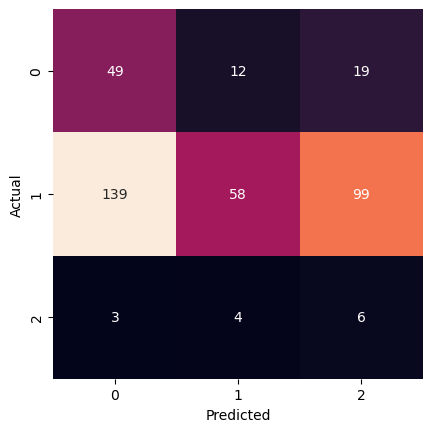

In [512]:
plot_cm(clf)

**KNN**

In [513]:
# clf=KNeighborsClassifier()
# clf.fit(X_train,y_train)
# mscore=clf.score(X_test,y_test)
# print("The score is: ",mscore)
# scores_list.append(mscore)

**random forest**

In [514]:
# clf=RandomForestClassifier(300)
# clf.fit(X_train,y_train)
# mscore=clf.score(X_test,y_test)
# print("The score is: ",mscore)
# scores_list.append(mscore)

**Light gradient boosting machine (LGBM)**

In [515]:
clf=LGBMClassifier(random_state=0,class_weight="balanced")
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

The score is:  0.7712082262210797
The balanced accuracy is:  0.5238825363825365


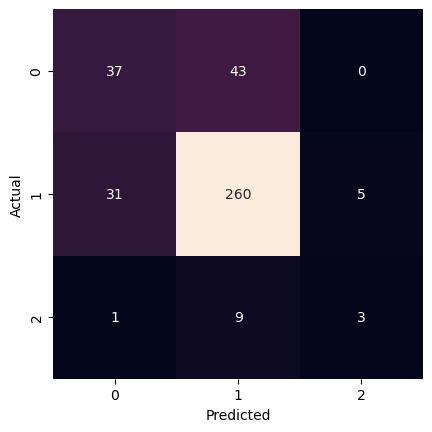

In [516]:
plot_cm(clf)

**XGBOOST**

with help from [Unbalanced multiclass data with XGBoost]("https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost")

In [517]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [518]:
clf=XGBClassifier(use_label_encoder=False,random_state=0)
clf.fit(X_train,y_train,sample_weight=classes_weights)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

[12:09:48] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The score is:  0.7789203084832905
The balanced accuracy is:  0.5823717948717949


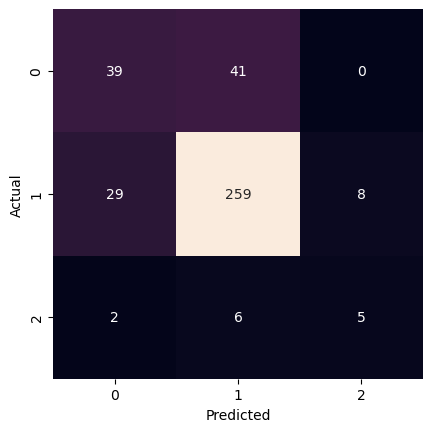

In [519]:
plot_cm(clf)

**catboost**

In [520]:
classes_weights

array([0.41639871, 0.41639871, 0.41639871, ..., 0.41639871, 0.41639871,
       0.41639871])

In [521]:
classes = np.unique(y_train)
weights = class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 2.072, 1: 0.41639871382636656, 2: 8.633333333333333}

In [522]:
clf=CatBoostClassifier(random_state=0,class_weights=class_weights)
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
mscore=clf.score(X_test,y_test)
balanced_score=balanced_accuracy_score(y_test,pred)
print("The score is: ",mscore)
print("The balanced accuracy is: ",balanced_score)
scores_list.append(balanced_score)

Learning rate set to 0.080926
0:	learn: 1.0495414	total: 10.6ms	remaining: 10.6s
1:	learn: 1.0186522	total: 20.1ms	remaining: 10s
2:	learn: 0.9759101	total: 29.9ms	remaining: 9.93s
3:	learn: 0.9490906	total: 41.2ms	remaining: 10.3s
4:	learn: 0.9234281	total: 50.9ms	remaining: 10.1s
5:	learn: 0.8949289	total: 62.1ms	remaining: 10.3s
6:	learn: 0.8675000	total: 73ms	remaining: 10.4s
7:	learn: 0.8388359	total: 82.2ms	remaining: 10.2s
8:	learn: 0.8240227	total: 92.8ms	remaining: 10.2s
9:	learn: 0.8053248	total: 104ms	remaining: 10.3s
10:	learn: 0.7864068	total: 126ms	remaining: 11.4s
11:	learn: 0.7717848	total: 137ms	remaining: 11.3s
12:	learn: 0.7533283	total: 148ms	remaining: 11.2s
13:	learn: 0.7376632	total: 159ms	remaining: 11.2s
14:	learn: 0.7240241	total: 168ms	remaining: 11.1s
15:	learn: 0.7129391	total: 177ms	remaining: 10.9s
16:	learn: 0.7002983	total: 188ms	remaining: 10.8s
17:	learn: 0.6915060	total: 197ms	remaining: 10.7s
18:	learn: 0.6788212	total: 209ms	remaining: 10.8s
19:	le

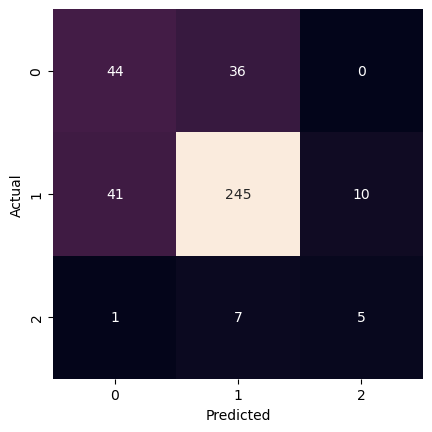

In [523]:
plot_cm(clf)

putting it all together

In [524]:
scores_list

[0.670556133056133,
 0.3322072072072072,
 0.6414241164241163,
 0.42332813582813583,
 0.5238825363825365,
 0.5823717948717949,
 0.5874393624393625]

In [525]:
sb=pd.DataFrame(list(zip(classifiers,scores_list)),columns=['Classifier','Score'])
sb.sort_values("Score")

,Classifier,Score
1,svc rbf,0.332207
3,Naive Bayes,0.423328
4,Light Gradient Boosting machine(LGBM),0.523883
5,xgboost,0.582372
6,catboost,0.587439
2,Logistic Regression,0.641424
0,svc linear,0.670556


### Gridsearch
Now we will try to squeeze the last drops of performance out of our best model, the svc with linear kernel

In [526]:
linear_svc_grid={
    "kernel":["linear"],
    "C":[0.01,0.1,1,10,100],

}
# LGBM_grid = {'n_estimators': [50, 100, 150, 200],
#         'max_depth': [4, 8, 12],
#         'learning_rate': [0.05, 0.1, 0.15]}
xgboost_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

catboost_grid={'learning_rate': [0.01, 0.1,1],
        'n_estimators':[100,200,400],
        'depth': [4, 10,15,20,30],
        'l2_leaf_reg': [0,1, 3, 5, 9]}

# rf_grid={
#     "n_estimators":[100,200,300,400],
#     "max_depth":[1,2,3,4,5,6,7,8],
#     'min_samples_leaf':[2,4]
# }

log_grid={
    "penalty":["l1", "l2", "elasticnet" , "none" ],
    "C":[0.01,0.1,1,10],
    "max_iter":[100,150,200,300]
}
final_class=['linear_svc','xgboost_classifier','catboost_classifier','logistic_regression']
final_scores=[]

In [527]:
from joblib import dump, load


Fitting 5 folds for each of 5 candidates, totalling 25 fits


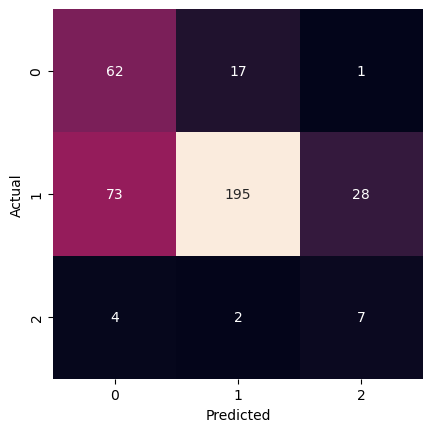

In [528]:
linear_svc_clf=GridSearchCV(estimator=SVC(class_weight="balanced"),param_grid=linear_svc_grid,n_jobs=1,cv=5,verbose=True)
linear_svc_clf.fit(X_train,y_train)
dump(linear_svc_clf, 'linear_svc_clf.joblib')

pred=linear_svc_clf.predict(X_test)
balanced_score=balanced_accuracy_score(y_test,pred)
final_scores.append(balanced_score)
plot_cm(linear_svc_clf)

In [529]:
xgboost_clf=GridSearchCV(estimator=XGBClassifier(use_label_encoder=False),param_grid=xgboost_grid,n_jobs=1,cv=5,verbose=True)

#Fit the model
xgboost_clf.fit(X_train,y_train,sample_weight=classes_weights)
#Score and Store the model
dump(xgboost_clf, 'xgboost_clf.joblib') 

pred=xgboost_clf.predict(X_test)
balanced_score=balanced_accuracy_score(y_test,pred)
final_scores.append(balanced_score)
plot_cm(xgboost_clf)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
[12:10:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:10:28] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:10:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_me

KeyboardInterrupt: 

In [ ]:
catboost_clf=GridSearchCV(estimator=CatBoostClassifier(class_weights=class_weights),param_grid=catboost_grid,n_jobs=1,cv=5,verbose=True)

#Fit the model
catboost_clf.fit(X_train,y_train)
dump(catboost_clf, 'catboost_clf.joblib') 

pred=catboost_clf.predict(X_test)
balanced_score=balanced_accuracy_score(y_test,pred)
final_scores.append(balanced_score)
plot_cm(catboost_clf)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits
0:	learn: 1.0876134	total: 3.65ms	remaining: 362ms
1:	learn: 1.0775731	total: 7.37ms	remaining: 361ms
2:	learn: 1.0678988	total: 9.33ms	remaining: 302ms
3:	learn: 1.0582217	total: 13ms	remaining: 311ms
4:	learn: 1.0482321	total: 17.9ms	remaining: 341ms
5:	learn: 1.0385365	total: 22.7ms	remaining: 356ms
6:	learn: 1.0296898	total: 28.1ms	remaining: 373ms
7:	learn: 1.0205464	total: 35.3ms	remaining: 406ms
8:	learn: 1.0123893	total: 39.9ms	remaining: 404ms
9:	learn: 1.0041383	total: 48ms	remaining: 432ms
10:	learn: 0.9960756	total: 55.7ms	remaining: 451ms
11:	learn: 0.9878445	total: 60.6ms	remaining: 444ms
12:	learn: 0.9800751	total: 68ms	remaining: 455ms
13:	learn: 0.9720723	total: 72.8ms	remaining: 447ms
14:	learn: 0.9647043	total: 78.1ms	remaining: 442ms
15:	learn: 0.9575131	total: 84.8ms	remaining: 445ms
16:	learn: 0.9495671	total: 89.8ms	remaining: 438ms
17:	learn: 0.9419067	total: 94.8ms	remaining: 432ms
18:	learn: 0.934

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.8405501	total: 3.01ms	remaining: 298ms
1:	learn: 499.5086777	total: 8.19ms	remaining: 401ms
2:	learn: 537.6759315	total: 11.7ms	remaining: 377ms
3:	learn: 492.1817088	total: 15.3ms	remaining: 366ms
4:	learn: 383.7339764	total: 18.4ms	remaining: 350ms
5:	learn: 472.5796720	total: 24.5ms	remaining: 384ms
6:	learn: 384.8014805	total: 27.8ms	remaining: 369ms
7:	learn: 369.3396959	total: 31.1ms	remaining: 358ms
8:	learn: 352.2076663	total: 34.3ms	remaining: 347ms
9:	learn: 432.4333384	total: 45ms	remaining: 405ms
10:	learn: 377.8846549	total: 50ms	remaining: 405ms
11:	learn: 341.9883586	total: 53.5ms	remaining: 392ms
12:	learn: 380.3420861	total: 60.3ms	remaining: 404ms
13:	learn: 333.6846733	total: 64.3ms	remaining: 395ms
14:	learn: 310.4775741	total: 67.5ms	remaining: 383ms
15:	learn: 297.3027349	total: 73.3ms	remaining: 385ms
16:	learn: 276.8480564	total: 76.8ms	remaining: 375ms
17:	learn: 229.2804816	total: 80.5ms	remaining: 367ms
18:	learn: 220.7871893	total: 83.9ms	remaini

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.3878097	total: 7.92ms	remaining: 784ms
1:	learn: 545.8386838	total: 11.6ms	remaining: 568ms
2:	learn: 384.9181087	total: 15.4ms	remaining: 497ms
3:	learn: 243.8178609	total: 19.7ms	remaining: 474ms
4:	learn: 247.0312272	total: 23.6ms	remaining: 448ms
5:	learn: 239.7203977	total: 46.2ms	remaining: 724ms
6:	learn: 229.6070496	total: 49.6ms	remaining: 658ms
7:	learn: 193.2382171	total: 54.9ms	remaining: 632ms
8:	learn: 207.1979425	total: 58.6ms	remaining: 593ms
9:	learn: 193.5018309	total: 62.5ms	remaining: 563ms
10:	learn: 202.9486408	total: 65.9ms	remaining: 533ms
11:	learn: 190.0980991	total: 71ms	remaining: 520ms
12:	learn: 332.9853467	total: 74.5ms	remaining: 498ms
13:	learn: 267.8482446	total: 78.5ms	remaining: 482ms
14:	learn: 250.0126500	total: 82ms	remaining: 465ms
15:	learn: 247.2705587	total: 87.6ms	remaining: 460ms
16:	learn: 201.9330625	total: 92.3ms	remaining: 451ms
17:	learn: 216.4952786	total: 97.6ms	remaining: 445ms
18:	learn: 196.7086272	total: 104ms	remainin

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.8348417	total: 3.79ms	remaining: 375ms
1:	learn: 1498.8656908	total: 10.1ms	remaining: 493ms
2:	learn: 605.7012850	total: 14ms	remaining: 454ms
3:	learn: 592.4435357	total: 17.7ms	remaining: 425ms
4:	learn: 497.7381844	total: 20.9ms	remaining: 396ms
5:	learn: 440.2935898	total: 25.9ms	remaining: 406ms
6:	learn: 472.6773935	total: 29.4ms	remaining: 390ms
7:	learn: 631.5640184	total: 32.6ms	remaining: 374ms
8:	learn: 627.2436371	total: 36.1ms	remaining: 365ms
9:	learn: 590.0387374	total: 41.1ms	remaining: 370ms
10:	learn: 640.7791925	total: 44.5ms	remaining: 360ms
11:	learn: 618.9707274	total: 47.9ms	remaining: 352ms
12:	learn: 479.2950618	total: 51.6ms	remaining: 345ms
13:	learn: 412.8897271	total: 57.5ms	remaining: 353ms
14:	learn: 364.1081687	total: 62.3ms	remaining: 353ms
15:	learn: 300.2615665	total: 65.9ms	remaining: 346ms
16:	learn: 295.4110497	total: 69.4ms	remaining: 339ms
17:	learn: 326.1608494	total: 75.2ms	remaining: 343ms
18:	learn: 299.0106353	total: 78.8ms	rema

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.4929333	total: 3.13ms	remaining: 310ms
1:	learn: 236.6600029	total: 6.82ms	remaining: 334ms
2:	learn: 412.7572634	total: 10.1ms	remaining: 328ms
3:	learn: 321.4293600	total: 16.1ms	remaining: 386ms
4:	learn: 263.8520180	total: 19.6ms	remaining: 372ms
5:	learn: 266.6836965	total: 23.2ms	remaining: 363ms
6:	learn: 259.9892664	total: 26.3ms	remaining: 349ms
7:	learn: 253.3917505	total: 33.2ms	remaining: 381ms
8:	learn: 265.6441558	total: 38ms	remaining: 384ms
9:	learn: 235.9313671	total: 41.9ms	remaining: 377ms
10:	learn: 195.0231653	total: 49.4ms	remaining: 400ms
11:	learn: 188.3164172	total: 53.6ms	remaining: 393ms
12:	learn: 195.3147785	total: 58ms	remaining: 388ms
13:	learn: 242.8487131	total: 63.6ms	remaining: 391ms
14:	learn: 171.0135498	total: 68.2ms	remaining: 386ms
15:	learn: 181.9617654	total: 71.6ms	remaining: 376ms
16:	learn: 193.7452213	total: 75ms	remaining: 366ms
17:	learn: 178.6451555	total: 84.1ms	remaining: 383ms
18:	learn: 172.7821261	total: 136ms	remaining:

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.9004551	total: 2.79ms	remaining: 276ms
1:	learn: 132.7042818	total: 6.01ms	remaining: 294ms
2:	learn: 400.1754642	total: 11.1ms	remaining: 360ms
3:	learn: 323.6870215	total: 15ms	remaining: 359ms
4:	learn: 228.8626610	total: 18.5ms	remaining: 352ms
5:	learn: 242.0863916	total: 22.2ms	remaining: 348ms
6:	learn: 207.9219447	total: 26.4ms	remaining: 350ms
7:	learn: 254.1659206	total: 29.6ms	remaining: 340ms
8:	learn: 192.0802531	total: 32.9ms	remaining: 333ms
9:	learn: 179.8650747	total: 36ms	remaining: 324ms
10:	learn: 191.0016227	total: 42.2ms	remaining: 341ms
11:	learn: 184.2952654	total: 45.5ms	remaining: 334ms
12:	learn: 221.0121814	total: 48.5ms	remaining: 325ms
13:	learn: 230.0343515	total: 51.5ms	remaining: 317ms
14:	learn: 189.8222170	total: 56.6ms	remaining: 321ms
15:	learn: 182.4905660	total: 60.1ms	remaining: 316ms
16:	learn: 154.9226014	total: 63.5ms	remaining: 310ms
17:	learn: 264.8133829	total: 66.7ms	remaining: 304ms
18:	learn: 222.2207172	total: 72.9ms	remaini

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.8405501	total: 5.87ms	remaining: 1.17s
1:	learn: 499.5086777	total: 9.27ms	remaining: 918ms
2:	learn: 537.6759315	total: 12.7ms	remaining: 836ms
3:	learn: 492.1817088	total: 16ms	remaining: 786ms
4:	learn: 383.7339764	total: 22.6ms	remaining: 880ms
5:	learn: 472.5796720	total: 27ms	remaining: 875ms
6:	learn: 384.8014805	total: 30.8ms	remaining: 849ms
7:	learn: 369.3396959	total: 34.5ms	remaining: 829ms
8:	learn: 352.2076663	total: 39.2ms	remaining: 831ms
9:	learn: 432.4333384	total: 42.5ms	remaining: 808ms
10:	learn: 377.8846549	total: 46.1ms	remaining: 792ms
11:	learn: 341.9883586	total: 51.8ms	remaining: 812ms
12:	learn: 380.3420861	total: 56.7ms	remaining: 815ms
13:	learn: 333.6846733	total: 60.6ms	remaining: 806ms
14:	learn: 310.4775741	total: 64.5ms	remaining: 796ms
15:	learn: 297.3027349	total: 78.1ms	remaining: 898ms
16:	learn: 276.8480564	total: 85.1ms	remaining: 916ms
17:	learn: 229.2804816	total: 88.9ms	remaining: 899ms
18:	learn: 220.7871893	total: 92.4ms	remaini

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.3878097	total: 2.94ms	remaining: 585ms
1:	learn: 545.8386838	total: 6.46ms	remaining: 639ms
2:	learn: 384.9181087	total: 9.66ms	remaining: 634ms
3:	learn: 243.8178609	total: 12.8ms	remaining: 628ms
4:	learn: 247.0312272	total: 16ms	remaining: 623ms
5:	learn: 239.7203977	total: 22.1ms	remaining: 715ms
6:	learn: 229.6070496	total: 25.6ms	remaining: 704ms
7:	learn: 193.2382171	total: 28.7ms	remaining: 690ms
8:	learn: 207.1979425	total: 32.2ms	remaining: 683ms
9:	learn: 193.5018309	total: 37.9ms	remaining: 721ms
10:	learn: 202.9486408	total: 42.4ms	remaining: 729ms
11:	learn: 190.0980991	total: 46.1ms	remaining: 722ms
12:	learn: 332.9853467	total: 49.4ms	remaining: 710ms
13:	learn: 267.8482446	total: 54.5ms	remaining: 724ms
14:	learn: 250.0126500	total: 58ms	remaining: 716ms
15:	learn: 247.2705587	total: 61.7ms	remaining: 710ms
16:	learn: 201.9330625	total: 65.2ms	remaining: 702ms
17:	learn: 216.4952786	total: 71.7ms	remaining: 725ms
18:	learn: 196.7086272	total: 75.2ms	remaini

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.8348417	total: 6.18ms	remaining: 1.23s
1:	learn: 1498.8656908	total: 10.6ms	remaining: 1.05s
2:	learn: 605.7012850	total: 14.6ms	remaining: 961ms
3:	learn: 592.4435357	total: 20.7ms	remaining: 1.01s
4:	learn: 497.7381844	total: 24.9ms	remaining: 973ms
5:	learn: 440.2935898	total: 29.1ms	remaining: 942ms
6:	learn: 472.6773935	total: 33.2ms	remaining: 914ms
7:	learn: 631.5640184	total: 40ms	remaining: 959ms
8:	learn: 627.2436371	total: 45.1ms	remaining: 956ms
9:	learn: 590.0387374	total: 48.7ms	remaining: 925ms
10:	learn: 640.7791925	total: 53.9ms	remaining: 926ms
11:	learn: 618.9707274	total: 57.4ms	remaining: 900ms
12:	learn: 479.2950618	total: 61.4ms	remaining: 883ms
13:	learn: 412.8897271	total: 64.9ms	remaining: 862ms
14:	learn: 364.1081687	total: 71.2ms	remaining: 878ms
15:	learn: 300.2615665	total: 74.9ms	remaining: 861ms
16:	learn: 295.4110497	total: 78.2ms	remaining: 842ms
17:	learn: 326.1608494	total: 81.7ms	remaining: 826ms
18:	learn: 299.0106353	total: 87.5ms	rema

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.4929333	total: 7.64ms	remaining: 1.52s
1:	learn: 236.6600029	total: 16.9ms	remaining: 1.67s
2:	learn: 412.7572634	total: 25ms	remaining: 1.64s
3:	learn: 321.4293600	total: 29.9ms	remaining: 1.46s
4:	learn: 263.8520180	total: 33.9ms	remaining: 1.32s
5:	learn: 266.6836965	total: 38.7ms	remaining: 1.25s
6:	learn: 259.9892664	total: 43.4ms	remaining: 1.2s
7:	learn: 253.3917505	total: 47.4ms	remaining: 1.14s
8:	learn: 265.6441558	total: 50.9ms	remaining: 1.08s
9:	learn: 235.9313671	total: 57.4ms	remaining: 1.09s
10:	learn: 195.0231653	total: 61.5ms	remaining: 1.06s
11:	learn: 188.3164172	total: 65ms	remaining: 1.02s
12:	learn: 195.3147785	total: 68.4ms	remaining: 984ms
13:	learn: 242.8487131	total: 73.9ms	remaining: 982ms
14:	learn: 171.0135498	total: 78.6ms	remaining: 969ms
15:	learn: 181.9617654	total: 81.9ms	remaining: 942ms
16:	learn: 193.7452213	total: 90.8ms	remaining: 977ms
17:	learn: 178.6451555	total: 94.2ms	remaining: 952ms
18:	learn: 172.7821261	total: 97.6ms	remainin

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.9004551	total: 7.75ms	remaining: 1.54s
1:	learn: 132.7042818	total: 23ms	remaining: 2.28s
2:	learn: 400.1754642	total: 34.8ms	remaining: 2.29s
3:	learn: 323.6870215	total: 38.8ms	remaining: 1.9s
4:	learn: 228.8626610	total: 42.7ms	remaining: 1.66s
5:	learn: 242.0863916	total: 47.3ms	remaining: 1.53s
6:	learn: 207.9219447	total: 51.4ms	remaining: 1.42s
7:	learn: 254.1659206	total: 54.6ms	remaining: 1.31s
8:	learn: 192.0802531	total: 57.8ms	remaining: 1.23s
9:	learn: 179.8650747	total: 63ms	remaining: 1.2s
10:	learn: 191.0016227	total: 66.2ms	remaining: 1.14s
11:	learn: 184.2952654	total: 69.3ms	remaining: 1.08s
12:	learn: 221.0121814	total: 72.5ms	remaining: 1.04s
13:	learn: 230.0343515	total: 78.3ms	remaining: 1.04s
14:	learn: 189.8222170	total: 81.8ms	remaining: 1.01s
15:	learn: 182.4905660	total: 85.4ms	remaining: 982ms
16:	learn: 154.9226014	total: 89.2ms	remaining: 961ms
17:	learn: 264.8133829	total: 98.1ms	remaining: 992ms
18:	learn: 222.2207172	total: 103ms	remaining:

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.8405501	total: 5.69ms	remaining: 1.7s
1:	learn: 499.5086777	total: 9.87ms	remaining: 1.47s
2:	learn: 537.6759315	total: 13.6ms	remaining: 1.35s
3:	learn: 492.1817088	total: 17.7ms	remaining: 1.31s
4:	learn: 383.7339764	total: 23.9ms	remaining: 1.41s
5:	learn: 472.5796720	total: 30.6ms	remaining: 1.5s
6:	learn: 384.8014805	total: 35.2ms	remaining: 1.47s
7:	learn: 369.3396959	total: 44ms	remaining: 1.6s
8:	learn: 352.2076663	total: 50.7ms	remaining: 1.64s
9:	learn: 432.4333384	total: 60.6ms	remaining: 1.76s
10:	learn: 377.8846549	total: 65.6ms	remaining: 1.72s
11:	learn: 341.9883586	total: 80.8ms	remaining: 1.94s
12:	learn: 380.3420861	total: 96ms	remaining: 2.12s
13:	learn: 333.6846733	total: 106ms	remaining: 2.17s
14:	learn: 310.4775741	total: 116ms	remaining: 2.21s
15:	learn: 297.3027349	total: 133ms	remaining: 2.37s
16:	learn: 276.8480564	total: 142ms	remaining: 2.37s
17:	learn: 229.2804816	total: 158ms	remaining: 2.47s
18:	learn: 220.7871893	total: 171ms	remaining: 2.53s

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.3878097	total: 3.37ms	remaining: 1.01s
1:	learn: 545.8386838	total: 7.26ms	remaining: 1.08s
2:	learn: 384.9181087	total: 11.9ms	remaining: 1.18s
3:	learn: 243.8178609	total: 16.3ms	remaining: 1.2s
4:	learn: 247.0312272	total: 19.6ms	remaining: 1.16s
5:	learn: 239.7203977	total: 23.1ms	remaining: 1.13s
6:	learn: 229.6070496	total: 27.8ms	remaining: 1.16s
7:	learn: 193.2382171	total: 31.2ms	remaining: 1.14s
8:	learn: 207.1979425	total: 34.5ms	remaining: 1.12s
9:	learn: 193.5018309	total: 38.4ms	remaining: 1.11s
10:	learn: 202.9486408	total: 43.6ms	remaining: 1.15s
11:	learn: 190.0980991	total: 47.7ms	remaining: 1.14s
12:	learn: 332.9853467	total: 51.7ms	remaining: 1.14s
13:	learn: 267.8482446	total: 55.7ms	remaining: 1.14s
14:	learn: 250.0126500	total: 63.3ms	remaining: 1.2s
15:	learn: 247.2705587	total: 69.8ms	remaining: 1.24s
16:	learn: 201.9330625	total: 77.5ms	remaining: 1.29s
17:	learn: 216.4952786	total: 83.2ms	remaining: 1.3s
18:	learn: 196.7086272	total: 88.9ms	remain

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.8348417	total: 9.33ms	remaining: 2.79s
1:	learn: 1498.8656908	total: 15.6ms	remaining: 2.32s
2:	learn: 605.7012850	total: 24.4ms	remaining: 2.42s
3:	learn: 592.4435357	total: 30ms	remaining: 2.22s
4:	learn: 497.7381844	total: 41.5ms	remaining: 2.45s
5:	learn: 440.2935898	total: 47.4ms	remaining: 2.32s
6:	learn: 472.6773935	total: 58.1ms	remaining: 2.43s
7:	learn: 631.5640184	total: 62.9ms	remaining: 2.29s
8:	learn: 627.2436371	total: 78.2ms	remaining: 2.53s
9:	learn: 590.0387374	total: 91.7ms	remaining: 2.66s
10:	learn: 640.7791925	total: 95.7ms	remaining: 2.51s
11:	learn: 618.9707274	total: 104ms	remaining: 2.5s
12:	learn: 479.2950618	total: 109ms	remaining: 2.4s
13:	learn: 412.8897271	total: 114ms	remaining: 2.32s
14:	learn: 364.1081687	total: 123ms	remaining: 2.33s
15:	learn: 300.2615665	total: 127ms	remaining: 2.25s
16:	learn: 295.4110497	total: 131ms	remaining: 2.19s
17:	learn: 326.1608494	total: 139ms	remaining: 2.17s
18:	learn: 299.0106353	total: 142ms	remaining: 2.1

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.4929333	total: 4.62ms	remaining: 1.38s
1:	learn: 236.6600029	total: 8.84ms	remaining: 1.32s
2:	learn: 412.7572634	total: 13.3ms	remaining: 1.31s
3:	learn: 321.4293600	total: 17ms	remaining: 1.26s
4:	learn: 263.8520180	total: 21.8ms	remaining: 1.29s
5:	learn: 266.6836965	total: 25.3ms	remaining: 1.24s
6:	learn: 259.9892664	total: 28.6ms	remaining: 1.2s
7:	learn: 253.3917505	total: 32.1ms	remaining: 1.17s
8:	learn: 265.6441558	total: 36.6ms	remaining: 1.18s
9:	learn: 235.9313671	total: 41ms	remaining: 1.19s
10:	learn: 195.0231653	total: 44.9ms	remaining: 1.18s
11:	learn: 188.3164172	total: 48.3ms	remaining: 1.16s
12:	learn: 195.3147785	total: 53.1ms	remaining: 1.17s
13:	learn: 242.8487131	total: 56.6ms	remaining: 1.16s
14:	learn: 171.0135498	total: 60.7ms	remaining: 1.15s
15:	learn: 181.9617654	total: 64.4ms	remaining: 1.14s
16:	learn: 193.7452213	total: 69.4ms	remaining: 1.15s
17:	learn: 178.6451555	total: 72.9ms	remaining: 1.14s
18:	learn: 172.7821261	total: 76.5ms	remainin

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.9004551	total: 5.22ms	remaining: 1.56s
1:	learn: 132.7042818	total: 10.2ms	remaining: 1.52s
2:	learn: 400.1754642	total: 14.1ms	remaining: 1.4s
3:	learn: 323.6870215	total: 18.8ms	remaining: 1.39s
4:	learn: 228.8626610	total: 22.2ms	remaining: 1.31s
5:	learn: 242.0863916	total: 25.4ms	remaining: 1.24s
6:	learn: 207.9219447	total: 28.8ms	remaining: 1.21s
7:	learn: 254.1659206	total: 33.1ms	remaining: 1.21s
8:	learn: 192.0802531	total: 36.6ms	remaining: 1.18s
9:	learn: 179.8650747	total: 39.8ms	remaining: 1.16s
10:	learn: 191.0016227	total: 43.1ms	remaining: 1.13s
11:	learn: 184.2952654	total: 46.1ms	remaining: 1.1s
12:	learn: 221.0121814	total: 50.4ms	remaining: 1.11s
13:	learn: 230.0343515	total: 54.2ms	remaining: 1.11s
14:	learn: 189.8222170	total: 57.8ms	remaining: 1.1s
15:	learn: 182.4905660	total: 60.8ms	remaining: 1.08s
16:	learn: 154.9226014	total: 64.6ms	remaining: 1.07s
17:	learn: 264.8133829	total: 68.5ms	remaining: 1.07s
18:	learn: 222.2207172	total: 71.7ms	remain

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.8405501	total: 24.7ms	remaining: 9.87s
1:	learn: 499.5086777	total: 30.3ms	remaining: 6.04s
2:	learn: 537.6759315	total: 34.2ms	remaining: 4.52s
3:	learn: 492.1817088	total: 37.9ms	remaining: 3.76s
4:	learn: 383.7339764	total: 41.2ms	remaining: 3.26s
5:	learn: 472.5796720	total: 45.9ms	remaining: 3.01s
6:	learn: 384.8014805	total: 49.8ms	remaining: 2.8s
7:	learn: 369.3396959	total: 53.6ms	remaining: 2.63s
8:	learn: 352.2076663	total: 57.5ms	remaining: 2.5s
9:	learn: 432.4333384	total: 62.4ms	remaining: 2.43s
10:	learn: 377.8846549	total: 66.1ms	remaining: 2.34s
11:	learn: 341.9883586	total: 69.7ms	remaining: 2.25s
12:	learn: 380.3420861	total: 73.1ms	remaining: 2.18s
13:	learn: 333.6846733	total: 77.7ms	remaining: 2.14s
14:	learn: 310.4775741	total: 81.3ms	remaining: 2.09s
15:	learn: 297.3027349	total: 85ms	remaining: 2.04s
16:	learn: 276.8480564	total: 88.5ms	remaining: 1.99s
17:	learn: 229.2804816	total: 93.4ms	remaining: 1.98s
18:	learn: 220.7871893	total: 96.8ms	remaini

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.3878097	total: 4.83ms	remaining: 1.93s
1:	learn: 545.8386838	total: 16.2ms	remaining: 3.22s
2:	learn: 384.9181087	total: 21.6ms	remaining: 2.85s
3:	learn: 243.8178609	total: 33.1ms	remaining: 3.28s
4:	learn: 247.0312272	total: 37.5ms	remaining: 2.96s
5:	learn: 239.7203977	total: 46.4ms	remaining: 3.05s
6:	learn: 229.6070496	total: 53.8ms	remaining: 3.02s
7:	learn: 193.2382171	total: 62ms	remaining: 3.04s
8:	learn: 207.1979425	total: 65.7ms	remaining: 2.85s
9:	learn: 193.5018309	total: 68.9ms	remaining: 2.69s
10:	learn: 202.9486408	total: 76.6ms	remaining: 2.71s
11:	learn: 190.0980991	total: 80.3ms	remaining: 2.6s
12:	learn: 332.9853467	total: 83.4ms	remaining: 2.48s
13:	learn: 267.8482446	total: 86.6ms	remaining: 2.39s
14:	learn: 250.0126500	total: 93.6ms	remaining: 2.4s
15:	learn: 247.2705587	total: 127ms	remaining: 3.04s
16:	learn: 201.9330625	total: 130ms	remaining: 2.93s
17:	learn: 216.4952786	total: 133ms	remaining: 2.82s
18:	learn: 196.7086272	total: 136ms	remaining: 

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.8348417	total: 7.48ms	remaining: 2.98s
1:	learn: 1498.8656908	total: 11.6ms	remaining: 2.31s
2:	learn: 605.7012850	total: 15.6ms	remaining: 2.06s
3:	learn: 592.4435357	total: 22.4ms	remaining: 2.22s
4:	learn: 497.7381844	total: 28.8ms	remaining: 2.27s
5:	learn: 440.2935898	total: 33.6ms	remaining: 2.21s
6:	learn: 472.6773935	total: 42ms	remaining: 2.36s
7:	learn: 631.5640184	total: 45.8ms	remaining: 2.24s
8:	learn: 627.2436371	total: 50.9ms	remaining: 2.21s
9:	learn: 590.0387374	total: 54.5ms	remaining: 2.13s
10:	learn: 640.7791925	total: 58ms	remaining: 2.05s
11:	learn: 618.9707274	total: 61.5ms	remaining: 1.99s
12:	learn: 479.2950618	total: 64.6ms	remaining: 1.92s
13:	learn: 412.8897271	total: 68.9ms	remaining: 1.9s
14:	learn: 364.1081687	total: 72ms	remaining: 1.85s
15:	learn: 300.2615665	total: 75.1ms	remaining: 1.8s
16:	learn: 295.4110497	total: 78.1ms	remaining: 1.76s
17:	learn: 326.1608494	total: 81.7ms	remaining: 1.73s
18:	learn: 299.0106353	total: 85.8ms	remaining:

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 3.4929333	total: 6.8ms	remaining: 2.71s
1:	learn: 236.6600029	total: 11.1ms	remaining: 2.21s
2:	learn: 412.7572634	total: 15.4ms	remaining: 2.04s
3:	learn: 321.4293600	total: 22.1ms	remaining: 2.19s
4:	learn: 263.8520180	total: 26.4ms	remaining: 2.09s
5:	learn: 266.6836965	total: 35.8ms	remaining: 2.35s
6:	learn: 259.9892664	total: 41ms	remaining: 2.3s
7:	learn: 253.3917505	total: 44.9ms	remaining: 2.2s
8:	learn: 265.6441558	total: 48.4ms	remaining: 2.1s
9:	learn: 235.9313671	total: 53.2ms	remaining: 2.08s
10:	learn: 195.0231653	total: 56.3ms	remaining: 1.99s
11:	learn: 188.3164172	total: 59.6ms	remaining: 1.93s
12:	learn: 195.3147785	total: 63.3ms	remaining: 1.88s
13:	learn: 242.8487131	total: 68ms	remaining: 1.88s
14:	learn: 171.0135498	total: 72ms	remaining: 1.85s
15:	learn: 181.9617654	total: 75.4ms	remaining: 1.81s
16:	learn: 193.7452213	total: 78.7ms	remaining: 1.77s
17:	learn: 178.6451555	total: 83.1ms	remaining: 1.76s
18:	learn: 172.7821261	total: 86.6ms	remaining: 1.

learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.
learning rate is greater than 1. You probably need to decrease learning rate.


0:	learn: 2.9004551	total: 3.46ms	remaining: 1.38s
1:	learn: 132.7042818	total: 7.42ms	remaining: 1.48s
2:	learn: 400.1754642	total: 12.4ms	remaining: 1.65s
3:	learn: 323.6870215	total: 16.3ms	remaining: 1.61s
4:	learn: 228.8626610	total: 19.7ms	remaining: 1.56s
5:	learn: 242.0863916	total: 23ms	remaining: 1.51s
6:	learn: 207.9219447	total: 27.9ms	remaining: 1.57s
7:	learn: 254.1659206	total: 31ms	remaining: 1.52s
8:	learn: 192.0802531	total: 34.2ms	remaining: 1.48s
9:	learn: 179.8650747	total: 37.5ms	remaining: 1.46s
10:	learn: 191.0016227	total: 41.2ms	remaining: 1.46s
11:	learn: 184.2952654	total: 45ms	remaining: 1.45s
12:	learn: 221.0121814	total: 48.5ms	remaining: 1.44s
13:	learn: 230.0343515	total: 51.7ms	remaining: 1.43s
14:	learn: 189.8222170	total: 54.9ms	remaining: 1.41s
15:	learn: 182.4905660	total: 59.5ms	remaining: 1.43s
16:	learn: 154.9226014	total: 62.8ms	remaining: 1.42s
17:	learn: 264.8133829	total: 66.1ms	remaining: 1.4s
18:	learn: 222.2207172	total: 69.6ms	remaining:

KeyboardInterrupt: 

In [ ]:
log_reg_clf=GridSearchCV(estimator=LogisticRegression(class_weight="balanced"),param_grid=log_grid,n_jobs=1,cv=5,verbose=True)

#Fit the model
log_reg_clf.fit(X_train,y_train)

dump(log_reg_clf, 'logistic_regression.joblib') 
#Score and Store the model
pred=log_reg_clf.predict(X_test)
balanced_score=balanced_accuracy_score(y_test,pred)
final_scores.append(balanced_score)
plot_cm(log_reg_clf)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


d:\programmas_unif\miniconda\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\programmas_unif\miniconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\programmas_unif\miniconda\lib\site-packages\sklearn\linear_model\_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
d:\programmas_unif\miniconda\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed

In [ ]:
final_sb=pd.DataFrame(list(zip(final_class,final_scores)),columns=['Classifier','Score'])
final_sb

als moeilijk gaat om expensive restaurants eruit te halen probeer die eruit te krijgen met isolation forest of pca en de rest met binary classifiation

voor de laatste kan je dan grid search doen